## Inject Bugs & Run Experiment

![Inject Bugs & Run Experiment](./pic/RL_Testing.drawio.png)

#### Frozenlake Testbed Experiment

- Find log files in RLTestig/logs/frozenlake

In [ ]:
import bug_lib as BL


bug_version_list = [
    [],
    [0],
    [1],
    [2],
    [3],
    [4],
    [6],
    [7],
    [8],
    [9],
    [10],
    [11],
    [12],
    [13],
    [14],
    [15],
]

bug_version = []


In [ ]:
BL.cover_then_inject_bugs(bug_version)
# After this step, Restart the ipynb environment

In [ ]:
import frozenlake.testing_SB3_Frozenlake as Frozenlake_Experiment
Frozenlake_Experiment.main(bug_version=bug_version, rounds=10, epochs=300, model_type='ppo')

#### Mountaincar Testbed (continous) Experiment

- Find log files in RLTestig/logs/mountaincar

In [ ]:
import bug_lib as BL


bug_version_list = [
    [],
    [5],
    [6],
    [7],
    [8],
    [10],
    [11],
    [12],
    [13],
    [14],
    [15]
]

bug_version = [31]

In [ ]:
BL.cover_then_inject_bugs(bug_version)

In [ ]:
import mountaincar.testing_SB3_Mountaincar as Mountaincar_Experiment


Mountaincar_Experiment.main(bug_version=bug_version, rounds=10, epochs=700, model_type='a2c', max_steps=500)

## Validation Part

In [1]:
import log_parser
import pandas as pd
import scipy.stats as stats
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import config_parser
from scipy.stats import binomtest

In [64]:
def find_converge_point(data, n, epsilon):
    """
    n: the minimum number of points after the converge point that follows epsilon converge rule.
    """

    #calculate step differnece
    data = np.array(data)
    shifted_data = np.roll(data, 1)
    shifted_data[0] = 0
    step_diff = abs(data - shifted_data)

    #Find the epsilon converge points
    epsilon_converge = np.zeros_like(step_diff)
    for i in range(2, len(step_diff)):
        if step_diff[i] < step_diff[i - 1] * epsilon + 0.05:
            epsilon_converge[i] = 1

    converge_point = -1
    temp = 0
    for i in range(2, len(epsilon_converge)):
        if epsilon_converge[i] == 1:
            temp += 1
        else:
            temp = 0
        if temp > n:
            converge_point = i - n + 1
            break
    return converge_point

def find_converge_break_point(data, converge_point, lower_bound, n):
    """
    n: the maximum number of continuous outlier points after the converge point that we can tolerate.
    """

    converge_break_point = -1
    
    counter = 0
    continuous = False
    for i in range(converge_point + 1, len(data)):
        #Find continuous break point
        if data[i] < lower_bound:
            if not continuous:
                continuous = True
            counter += 1
        elif continuous:
            continuous = False
            counter = 0

        if counter >= n:
            converge_break_point = i - n + 1
            break
    
    return converge_break_point

In [67]:
root_dir = config_parser.parserConfig()['root_dir']
    
def analyze_data_trend_and_convergence_v2(data, trend_threshold=0, convergence_range=20, fluctuation_range=0.1, convergence_window_ratio=0.05, negative_fluctuation_limit=0.05, show=False, title="trend", confidence_level=0.95):
    slope, _, _, _, _ = linregress(range(len(data)), data)
    upwards_trend = slope > trend_threshold

    window_size = max(int(len(data) * convergence_window_ratio), 1)
    
    converge_point = find_converge_point(data, window_size, 0.999)
    converge_break_point = -1
    lower_bound = 0
    if converge_point != -1:
        lower_bound = data[converge_point] - np.ptp(data[converge_point: converge_point + window_size])

    if converge_point != -1:
        converge_break_point = find_converge_break_point(data, converge_point, lower_bound, window_size)

    # print(upwards_trend, no_large_negative_fluctuation, no_large_negative_fluctuation and upwards_trend)
    if show:
        plt.figure(figsize=(10, 5))
        plt.plot(data, marker='o', label='data')
        plt.plot(range(len(data)), [slope * x + data[0] for x in range(len(data))], 'r--', label=f'slope (slope={slope:.2f})')
        if converge_point != -1:
            plt.axvline(x=converge_point, color='g', linestyle='--', label='converge_point')
            plt.axhline(y=lower_bound, color='orange', linestyle='--', label='confidence_bottom')
            if converge_break_point != -1:
                plt.axvline(x=converge_break_point, color='r', linestyle='--', label='converge_break_point')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    return (upwards_trend, converge_point == -1)

def linear_regression_with_convergence_check(data, title='Data Trend Analysis', window_size=5, threshold=0.05, show=False):

    series = pd.Series(data)

    rolling_std = series.rolling(window=window_size).std()

    is_converged = rolling_std.iloc[-1] < threshold

    slope, intercept, r_value, p_value, std_err = linregress(range(len(data)), data)
    
    if show:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(data, label='Original Data', marker='o')
        plt.plot(range(len(data)), intercept + slope * np.asarray(range(len(data))), 'r', label=f'Trend Line: slope={slope:.2f}')
        plt.legend()
        plt.title(title)

        plt.subplot(1, 2, 2)
        plt.plot(rolling_std, label='Moving Standard Deviation')
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')
        plt.legend()
        plt.title('Data Convergence Check')
        
        plt.tight_layout()
        plt.show()
    if slope < 0 or not is_converged:
        return "false"
    else:
        return "true"

    

def test_true_proportion(num_samples, num_true, sig_level=0.05, expected_prob=0.95):
    p_value = binomtest(k=num_true, n=num_samples, p=expected_prob, alternative='greater')

    is_significant = p_value < sig_level

    return p_value, is_significant


def bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[]')), show_fig=False):
    bug_free_log_list = [file for file in bug_free_log_path.rglob('*') if file.is_file()]
    print(bug_free_log_list)

    result = []
    accuracy_result = []
    convergance_result = []
    for path in bug_free_log_list:
        # print(log_parser.parse_log_file(path))
        data = log_parser.parse_log_file_fuzzy(path)
        if len(data)> 0:
            # temp = linelar_regression(data, title=path, show=show_fig)
            # temp = linear_regression_with_convergence_check(data, title=path, show=show_fig)
            # temp = linear_regression_with_convergence_slop_check(data, title=path, show=show_fig)
            temp = analyze_data_trend_and_convergence_v2(data, title=path, show=show_fig)
        # result.append(temp)
        accuracy_result.append(temp[0])
        convergance_result.append(temp[1])
        result.append(temp[0] and temp[1])

    # p_value = binomtest(result.count('true'), len(result), alternative='greater')
    # print(p_value)
    print(binomtest(accuracy_result.count(True), len(result), alternative='greater'))
    print(binomtest(convergance_result.count(True), len(result), alternative='greater'))
    print(binomtest(result.count(True), len(result), alternative='greater'))

    
def bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'sac', '[]')), show_fig=False):
    # 使用 Path.rglob() 获取所有子文件
    # '**/*' 表示匹配所有的文件和文件夹, 如果只想匹配文件, 使用 '**/*.*'
    bug_free_log_list = [file for file in bug_free_log_path.rglob('*') if file.is_file()]

    print(bug_free_log_list)

    # accuracy_list = []
    # 打印所有文件路径
    result = []
    accuracy_result = []
    convergance_result = []
    for path in bug_free_log_list:
        data = log_parser.parse_mountaincar_log_file(path)
        if len(data) > 0:
            # temp = linelar_regression(data, title=path, show=show_fig)
            # temp = linear_regression_with_convergence_slop_check(data, title=path, show=show_fig)
            temp = analyze_data_trend_and_convergence_v2(data, title=path, show=show_fig, convergence_range= 20)
        accuracy_result.append(temp[0])
        convergance_result.append(temp[1])
        result.append(temp[0] and temp[1])
    
    
    # p_value = binomtest(result.count('true'), len(result), alternative='greater')
    # print(p_value)
    print(binomtest(accuracy_result.count(True), len(result), alternative='greater'))
    print(binomtest(convergance_result.count(True), len(result), alternative='greater'))
    print(binomtest(result.count(True), len(result), alternative='greater'))

[WindowsPath('E:/University/research/shiyu/RL-testing-new/RLTesting/logs/Frozenlake/dqn/[20]/time_2024-03-08[20]round_0'), WindowsPath('E:/University/research/shiyu/RL-testing-new/RLTesting/logs/Frozenlake/dqn/[20]/time_2024-03-08[20]round_1'), WindowsPath('E:/University/research/shiyu/RL-testing-new/RLTesting/logs/Frozenlake/dqn/[20]/time_2024-03-08[20]round_2'), WindowsPath('E:/University/research/shiyu/RL-testing-new/RLTesting/logs/Frozenlake/dqn/[20]/time_2024-03-08[20]round_3'), WindowsPath('E:/University/research/shiyu/RL-testing-new/RLTesting/logs/Frozenlake/dqn/[20]/time_2024-03-08[20]round_4'), WindowsPath('E:/University/research/shiyu/RL-testing-new/RLTesting/logs/Frozenlake/dqn/[20]/time_2024-03-08[20]round_5'), WindowsPath('E:/University/research/shiyu/RL-testing-new/RLTesting/logs/Frozenlake/dqn/[20]/time_2024-03-08[20]round_6'), WindowsPath('E:/University/research/shiyu/RL-testing-new/RLTesting/logs/Frozenlake/dqn/[20]/time_2024-03-08[20]round_7'), WindowsPath('E:/Univers

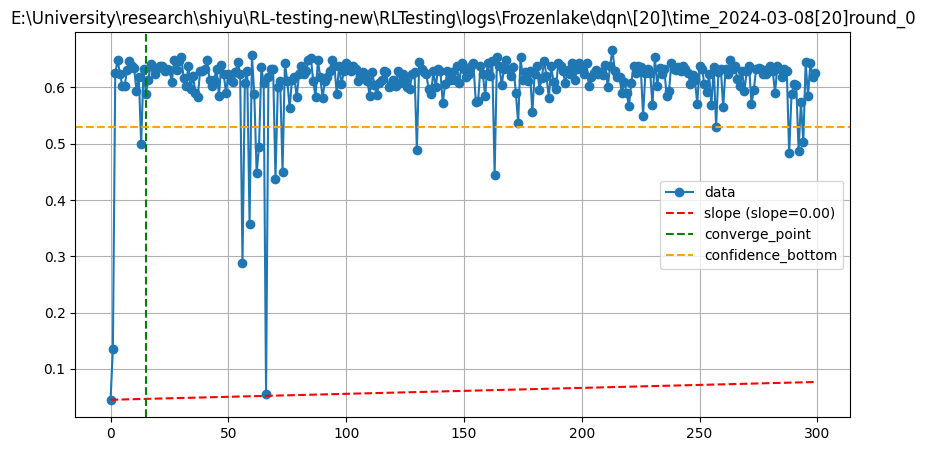

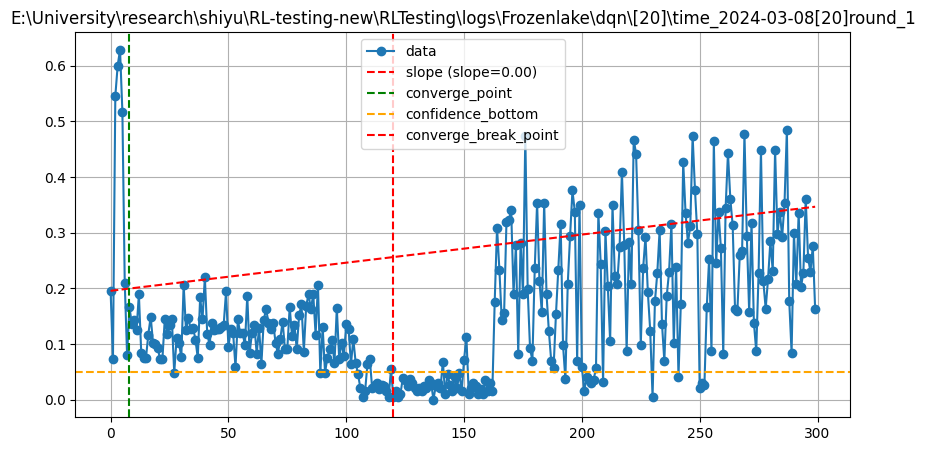

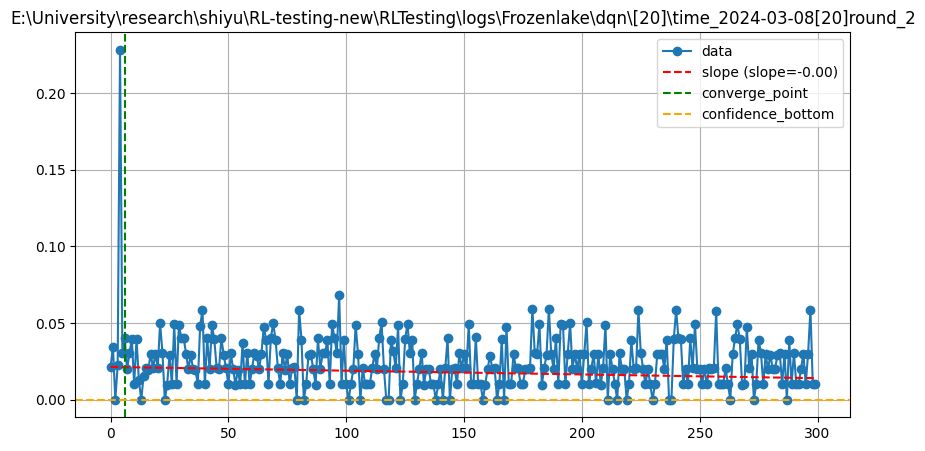

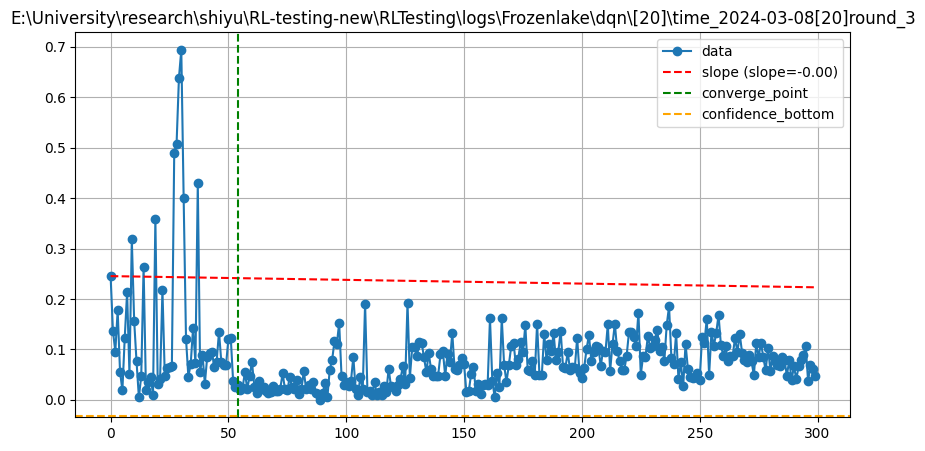

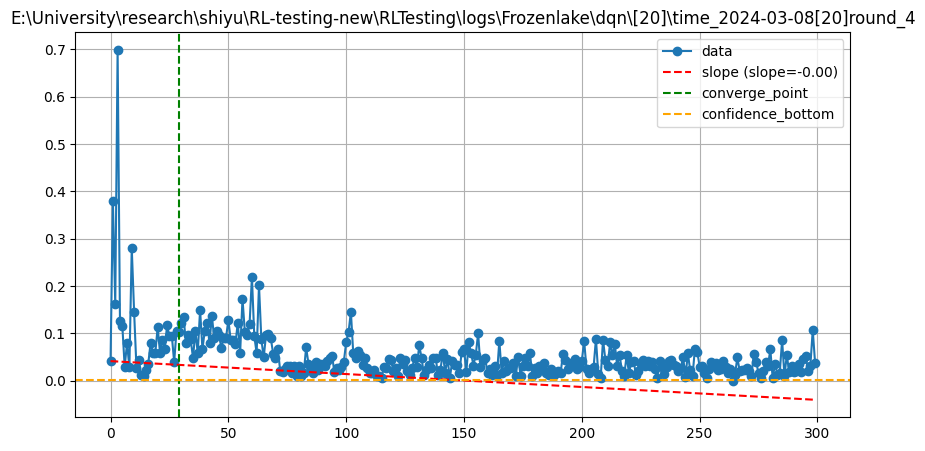

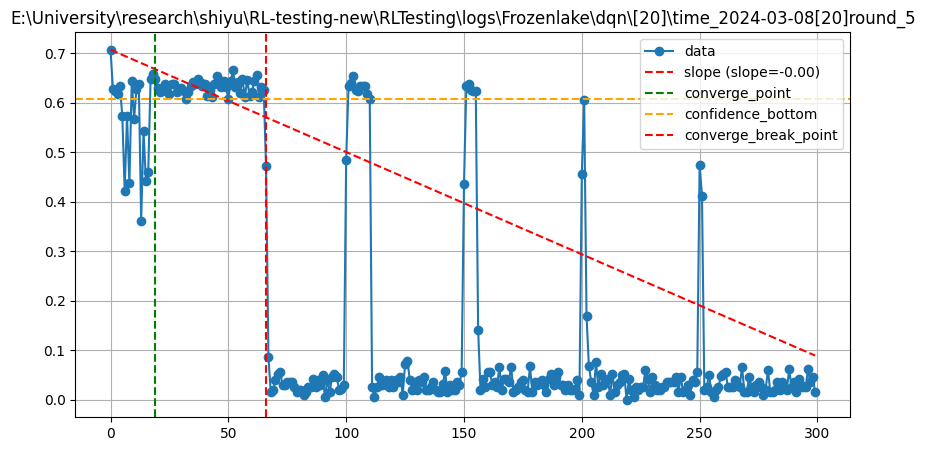

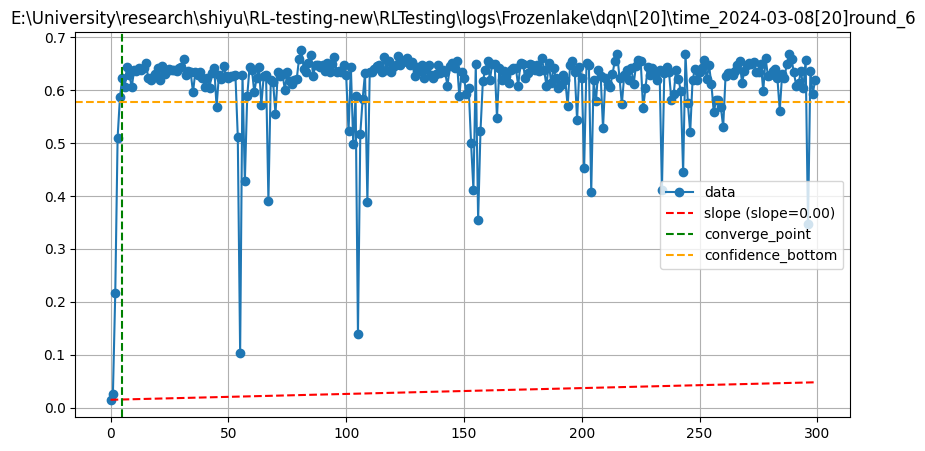

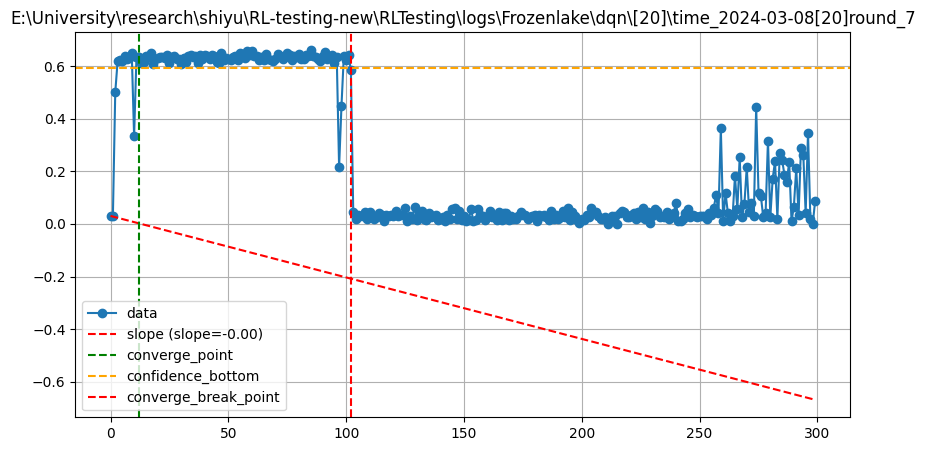

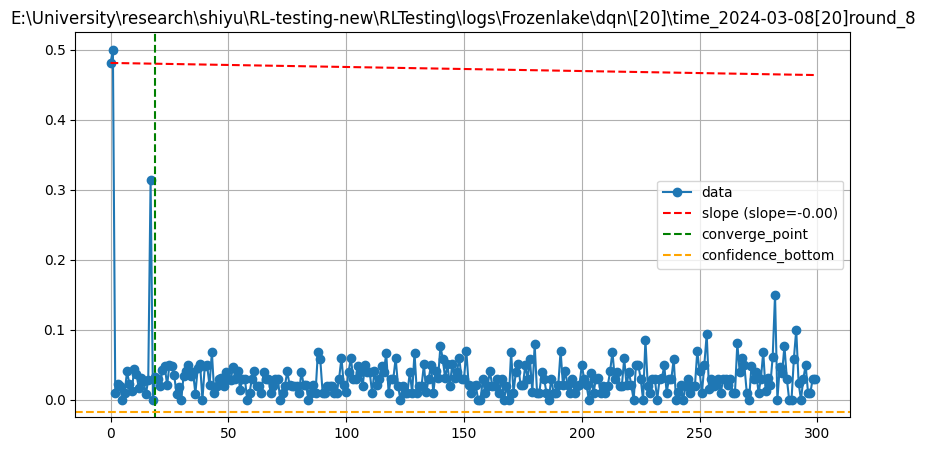

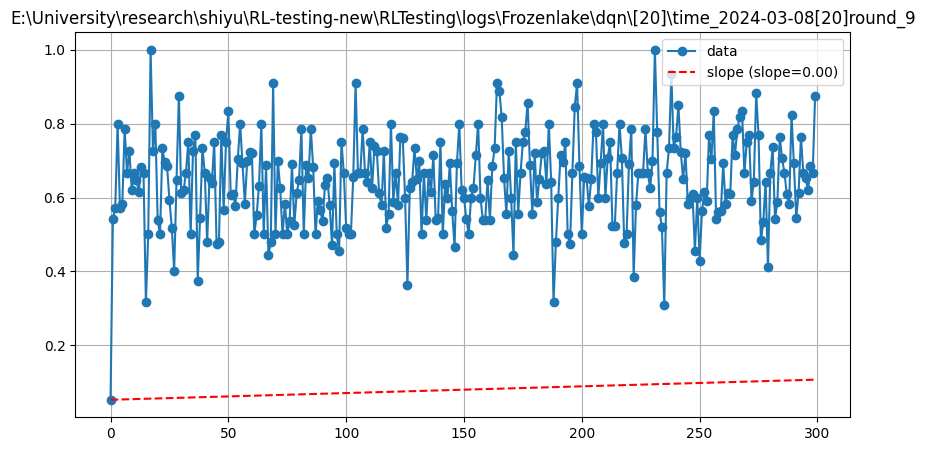

BinomTestResult(k=4, n=10, alternative='greater', statistic=0.4, pvalue=0.828125)
BinomTestResult(k=1, n=10, alternative='greater', statistic=0.1, pvalue=0.9990234375)
BinomTestResult(k=1, n=10, alternative='greater', statistic=0.1, pvalue=0.9990234375)


In [68]:
# bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'ppo', '[39]')), show_fig=True)
# bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'a2c', '[]')), show_fig=True)
# bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'sac', '[]')), show_fig=True)

# bug_list = [0, 1, 2, 4, 6, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23]
# bug_list = [24, 25, 26, 27, 28, 29, 30, 31, 32]
bug_list = [25, 26, 27, 28, 33, 34, 35, 36, 37, 38, 39]

bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[20]')), show_fig=True)
# for bug in bug_list:
#     bug = '[' + str(bug) + ']'
#     print(bug)
#     bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'ppo', bug)), show_fig=False)


In [ ]:
# bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[]')), show_fig=False)
# bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'ppo', '[]')), show_fig=True)
# bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'a2c', '[]1')), show_fig=False)


'''-------------------up bugfree--------------------down buggy----------------------'''



bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[0]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[1]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[2]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[4]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[6]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[9]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[10]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[16]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[17]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[18]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[19]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[20]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[21]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[22]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[23]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[24]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'ppo', '[7]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'ppo', '[9]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[24]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[25]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[26]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[27]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[28]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[29]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[30]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[31]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[32]')), show_fig=False)


